## Collecting Twitter Data

For collecting data from Twitter (Tweets), we use twitter streaming API and collect data using various crypto-currencies related keyword such as "crypto, cryptocurrency, bitcoin, #bitcoin, btc, #btc, eth, #eth, #ethereum, etc.". We are using both programming language R with "streamR" package and python with the "tweepy" library. We used both languages for achieving better datasets as stream API has some limitation and sometimes it became stop working and hence there can be a disruption in the collection process. We already collected more than 7 millions of tweets in this steps and stored as JSON. Later we process and clean up those data to reduce noise, duplication and irrelevant information using python.

The sample of the collected tweets as follows:

In [1]:
import json
with open('data/sample_1000_tweets.json', 'r') as f:
    lines = f.readlines() # read only the first tweet/line
    tweet = json.loads(lines[0]) # load first tweets as Python dict
    print(json.dumps(tweet, indent=4)) # pretty-print

{
    "created_at": "Sun Feb 18 17:55:02 +0000 2018",
    "id": 965283531667787776,
    "id_str": "965283531667787776",
    "text": "RT @CoinomiWallet: Announcing support for $LCC Litecoin Cash, $LTC's upcoming fork. To receive your free $LCC make sure you keep your $LTC\u2026",
    "source": "<a href=\"http://twitter.com\" rel=\"nofollow\">Twitter Web Client</a>",
    "truncated": false,
    "in_reply_to_status_id": null,
    "in_reply_to_status_id_str": null,
    "in_reply_to_user_id": null,
    "in_reply_to_user_id_str": null,
    "in_reply_to_screen_name": null,
    "user": {
        "id": 745181736129069056,
        "id_str": "745181736129069056",
        "name": "Decent Ape",
        "screen_name": "decentape",
        "location": "Denver, CO",
        "url": null,
        "description": "HODL so hard you forget you have it",
        "translator_type": "none",
        "protected": false,
        "verified": false,
        "followers_count": 39,
        "friends_count": 214,
     

A single tweet contains more than 100 attributes. However, all of those attributes may not useful for this projects. The primary attributes we would like to use for our analytics are <b>"created_at, id, text, source, user info (e.g. id, name, verified, followers_count, friends_count, favourites_count, etc.), retweeted_status, hashtags, urls, reply_count, retweet_count, favorite_count, timestamp_ms, etc</b>. 

The summarized meaning of each variable attribues is as follow:
- **created_at**: UTC time when this Tweet was created.
- **id**: The integer representation of the unique identifier for this Tweet. 
- **text**: The actual text of the status update.
- **source**: The source of the tweet if any.
- **retweeted_status**: Retweeted status of the tweet.
- **hashtags**: Used hashtags in the tweet.
- **urls**: The containing urls in the tweets if there any
- **reply_count**: Number of reply the tweets engazed.
- **retweet_count**: Number of retweet of the original tweet.
- **favorite_count**: Favorite count of the tweet.
- **timestamp_ms**: Time in miliseconds. 
<h5> User info: </h5><br>

- **id**: The unique identification number of the user.
- **name**: The name of the user who tweeted.
- **verified**: The verification status of the user profile.
- **followers_count**: Number of the followers of the user.
- **friends_count**: Number of the friends of the user.
- **favourites_count**: Favorites count of the user ID.



## Collecting Cryto-currency market price data

We would like to find out the impact and possible insight from the tweets and news regarding the market price and condition of We would like to find out the impact and possible insight from the tweets regarding the market price and condition of the cryptocurrencies. We used API of https://www.cryptocompare.com/ for this purpose. As the price is highly volatile and moves lots within minutes we performed our analytics to minutes data. We fetched the price of a crypto currency and stored that as a CSV file. Below is the sample of the CSV data.

In [2]:
import csv
with open('data/btc_sample.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    i=0
    for row in csvReader:
        print(row)
        if i>4:
            break
        i+=1

['time', 'timeDate', 'close', 'high', 'low', 'open', 'volumefrom', 'volumeto']
['1518892200000', '2018-02-17', '10796.54', '10806.39', '10754.02', '10754.04', '368.71', '3978742.34']
['1518892500000', '2018-02-17', '10811.53', '10817.22', '10794.84', '10796.54', '340.04', '3684537.56']
['1518892800000', '2018-02-17', '10794.36', '10814.95', '10785.52', '10811.54', '185.43', '2007962.74']
['1518893100000', '2018-02-17', '10793.61', '10802.96', '10789.15', '10795.68', '110.95', '1205334.76']
['1518893400000', '2018-02-17', '10797.93', '10801.49', '10771.55', '10790.18', '174.52', '1886536.28']


The crypto price data contains attributes such as <b>time, high, low, and volume information</b>. From those attributes, we can observe how the price is moving and what is the impact of social media and news on the price at a particular time. 

Now, let summarize the meaning of useful attributes.
- **time**: The time of the particular price point in miliseconds. 
- **high**: Highest price in that minute.
- **low**: Lowest prices in that minute.
- **volumefrom**: Starting trading volume.
- **volumeto**: Ending volume at that minute.

# Data manipulation 

Data manipulation is one of the challenging and crucial tasks for any data analytics project. In our project, we are dealing with different data sources. In this phase, we worked on Tweets data and Crypto Currency price data. Later we will also work on the news data in future phases. 

To analyze the twitter data, we fetched tweets for more than two weeks and we were able to collect more than 7 million (7000000) of tweets in this time frame. The size of our tweets was more than 43GB. This data contains some duplicates tweets, spam, and irrelevant tweets. As a result, we had to perform several data cleaning processes. Also, as the data size was more than 43GB we had to work with chunks of data rather than working with full data together. We divide the data set, extract the useful columns, merger dataset based on the columns. After merging we kept 20 files containing various columns of tweets and which become less than 10GB in size.  We also store data as MSGPACKS which allow us to further compress the data and it provides faster I/O read and write operation comparing to CSV and Pickle. 

<h3> We are including some of the data manipulation steps below: </h3>

## Twitter raw data manupulation

<h3>Importing necessary python libraries and combining the files</h3>

In [3]:
import glob
import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re
import operator 
from collections import Counter
from nltk import bigrams
import pandas as pd
import csv
import unicodecsv
from os import listdir
from os.path import isfile, join
import glob
import wordcloud
import matplotlib.pyplot as plt
#This function returns absolute path of all the files in a directory as a dictionary
def allFileNamesInDir(dirName, fileType):
#    itr = glob.glob(join(directory, fileType))
    itr = glob.glob(join(directory, fileType))
    dir_map={}
    for filename in itr:
        #print(re.search(r'\d{1,2}',filename).group(0))
        dir_map[int(re.search(r'\d{1,5}',filename).group(0))]=filename
    return dir_map

Initially, all the twitter data collected using twitter API is stored in json files within a directory called 'rawData'. Following codeblock is for loading all the json data file names from the directory and gathering them in a map to iterate in a sorted order.

In [4]:
parent_directory = ''
directory = join(parent_directory, 'rawData')
dir_map = allFileNamesInDir(directory,'*.json')

A new line is added after each tweet when data is collected from twitter API. Before we start cleaning tweeter data, we need to get rid of these new lines from the json files where tweets are written. We will remove empty lines from all the files and save them in a new directory called 'strippedRawData' and rename the files as 0.json, 1.json ...
<h4> No need to run the next codeblock if new lines are already removed </h4>

In [5]:
directory = join(parent_directory, 'strippedRawData')
newfile_name_format = directory+'{}'+'.json'

#for i in range(len(dir_map)):
for i in dir_map:
    with open(dir_map[i]) as infile, open(newfile_name_format.format(i), 'w') as outfile:
        for line in infile:
            if not line.strip(): continue  # skip the empty line
            outfile.write(line)  # non-empty line. Write it to output
    os.remove(dir_map[i]) # removing the old file

<h3> Processing the files, expanding useful columns and dropping unnecessary variables</h3>

Swing a tweet with all the fields when got from the Twitter API

In [6]:
line = None
with open(all_files[0],'r') as f:
    line = f.readline()
    
tweet =  json.loads(line)
tweet

{'contributors': None,
 'coordinates': None,
 'created_at': 'Tue Feb 13 23:09:37 +0000 2018',
 'display_text_range': [15, 140],
 'entities': {'hashtags': [],
  'symbols': [],
  'urls': [{'display_url': 'twitter.com/i/web/status/9…',
    'expanded_url': 'https://twitter.com/i/web/status/963550760012271616',
    'indices': [117, 140],
    'url': 'https://t.co/VX6ALHjESH'}],
  'user_mentions': [{'id': 1850835966,
    'id_str': '1850835966',
    'indices': [0, 14],
    'name': 'Criptominers',
    'screen_name': 'cripto_miners'}]},
 'extended_tweet': {'display_text_range': [15, 268],
  'entities': {'hashtags': [],
   'symbols': [],
   'urls': [],
   'user_mentions': [{'id': 1850835966,
     'id_str': '1850835966',
     'indices': [0, 14],
     'name': 'Criptominers',
     'screen_name': 'cripto_miners'}]},
  'full_text': '@cripto_miners Bitcoin Gold (BTG) is gaining popularity and becoming more expensive, but you still don’t own it? You have a unique chance to profit and exchange without co

Twitter data has a lot of parameters. Not all the parameters are useful for our specific application. Hence, we perform cleansing on raw twitter data and select following 26 variables that are most relevant to our application. We choose following 26 variables:

<ol>
  <li>id</li>
  <li>in_reply_to_user_id</li>
  <li>lang</li>
  <li>quoted_status_id</li>
  <li>retweet_count</li>
  <li>text</li>
  <li>entities</li>
  <li>coordinates</li>
  <li>created_at</li>
  <li>favorite_count</li>
  <li>favorited</li>
  <li>geo</li>
    
  <li>user_id</li>
  <li>user_created_at</li>
  <li>user_followers_count</li>
  <li>user_friends_count</li>
  <li>user_location</li>
  <li>user_screen_name</li>
  <li>user_verified</li>
  <li>user_description</li>
  
  <li>place_bounding_box</li>
  <li>place_country</li>
  <li>place_country_code</li>
  <li>place_full_name</li>
  <li>place_name</li>
  <li>place_place_type</li>

</ol>


We first create data frames from the stripped JSON data and then save them in msgpack (.msg) format. Tweets consist data object under parent object and more. Two of the parent data object ('user', and 'place') was important for our project. Hence, we expand those two columns and added the entities from those as separate data columns. 

In [7]:
#Finding all the files in directory as a list

stripped_directory = join(parent_directory, 'strippedRawData')
msg_dir = join(parent_directory, 'fulllData/')
output_msg_file_name_format = msg_dir +'{}'+'.msg'
stripped_input_files = allFileNamesInDir(stripped_directory,'.json')

#read the files and insert tweets into tweetsList
#for t in range(5,(len(onlyfiles))):
for t in range(0,len(stripped_input_files)):
    f = open(stripped_input_files[t], "r")
    lines = f.readlines()
    f.close
    x=0
    tweetsList = []
    for line in lines:
        try:
            tweet = json.loads(line)
            tweetsList.append(tweet)
            x= x+1;
        except Exception as e:
            continue
    #creating data frame
    tweets = pd.DataFrame(tweetsList)
    tweets = tweets[['coordinates', 'created_at',
   'favorite_count', 'favorited', 'geo', 'id','in_reply_to_user_id','lang', 'place',
   'quoted_status_id', 'retweet_count', 'text', 'user', 'entities']]
    #print(len(tweets))
    #print(tweets.head(1))

    #droping limit columns created due to empty lines
    if 'limit' in tweets.columns:
        tweets = tweets.drop(['limit'], axis=1)

    # dropping rows will all nan
    tweets = tweets.dropna(axis=0, how='all')

    #Adding user info to data frame columns
    l1 = ['user_id', 'user_created_at', 'user_followers_count', 'user_friends_count', 'user_location', 'user_screen_name', 'user_verified', 'user_description']
    l2 = ['id', 'created_at', 'followers_count', 'friends_count', 'location', 'screen_name', 'verified', 'description']
    l3 = ['place_bounding_box', 'place_country', 'place_country_code', 'place_full_name', 'place_name', 'place_place_type']
    l4 = ['bounding_box', 'country', 'country_code', 'full_name', 'name', 'place_type']
    
    #Adding location info to data frame columns
    
    for i in range(0, len(l1)):
        tweets[l1[i]] = list(map(lambda tweet: tweet[l2[i]] if tweet!= None else None, tweets['user'].tolist()))
        if i< len(l3):
            tweets[l3[i]] = list(map(lambda tweet: tweet[l4[i]] if tweet!= None else None, tweets['place'].tolist()))

    tweets = tweets.drop(['user', 'place'], axis=1)

#    tweets.head()
#     print('writing to output file = '+output_msg_file_name_format.format(t))
#     print('total columns = '+ str(len(tweets.columns)))
#     print('total rows = '+ str(len(tweets)))
    
    tweets.index = range(len(tweets.index))
    tweets.to_msgpack(output_msg_file_name_format.format(t))
#     print('wrote '+ output_msg_file_name_format.format(t))
#     print('--------------------------------------------------------------------------------------')
    

<h3>Merging the files into few master data files</h3>

The entire dataset is too big and not possible to work in a single data frame. In order to do the analysis and visualization more efficiently, we create few smaller dataframes and save them in seperate files.


In [8]:
#Finding all the files in directory as a list
mypath = 'fulllData/'
onlyfiles = [mypath+f for f in listdir(mypath) if isfile(join(mypath, f))]

df = pd.DataFrame()
fileNum = 1
for i in range(0, len(onlyfiles)):
    dfA = pd.read_msgpack(onlyfiles[i])
    df = df.append(dfA, ignore_index=True)
    if i%4==0 & i>1:
        #creating dataframe for useful columns groups    
        id_time_text = df[['id', 'created_at', 'text', 'favorite_count', 'retweet_count']]
        id_time_place_geo_coordinates_lang = df[['id', 'created_at', 'geo', 'coordinates', 'lang', 'place_bounding_box', 'place_country', 'place_country_code', 'place_full_name', 'place_name', 'place_place_type']]
        id_time_fCount_f_retweet_count_user = df[['id', 'created_at', 'favorite_count', 'favorited', 'retweet_count', 'user_id', 'user_created_at', 'user_followers_count', 'user_friends_count', 'user_location', 'user_screen_name', 'user_verified', 'user_description']]

        #saving all data frame to files
        df.to_msgpack('full_DataFrame/dataFile_'  + str(fileNum) +  '.msg')
        id_time_text.to_msgpack('full_DataFrame/id_time_text_'  + str(fileNum) +  '.msg')
        id_time_place_geo_coordinates_lang.to_msgpack('full_DataFrame/id_time_place_geo_coordinates_lang_' + str(fileNum) +'.msg')
        id_time_fCount_f_retweet_count_user.to_msgpack('full_DataFrame/id_time_fCount_f_retweet_count_user_' + str(fileNum) +'.msg')
        fileNum +=1
        df = pd.DataFrame()

The above codes provides us 20 final data files where 5 files consist the cleansed master data and rest of 15 files provide us the categorized data based on columns for particular types of application. For example, id_time_text_1.msg data provides us the tweets text along with tweets id and time. In this way, we were able to analyze the data various way with our machine. We use a machine with 32GB of pysical memory to process and further create visualization. However, still it was challenging for us due to the data size. 

## Manipulate the data for summarization and visualization

We had to further manipulate and process the data for various visualizations. Instead of adding those in this section of data manupulatin we shared those codes in the Data Summarization and Visualization (Section 4). However, some primary data manipulations are:

<h3>Process GEO data for creating Choropleth Map to show the user distribution over the world </h3>

In [9]:
# len(cdf['place_country'].dropna())
mypath = 'full_DataFrame/combined_data/geo_datas/'
onlyfiles = [mypath+f for f in listdir(mypath) if isfile(join(mypath, f))]
print(onlyfiles)
df_geo = pd.DataFrame()
dfA = pd.DataFrame()
for i in range(0, len(onlyfiles)):
    dfA = pd.read_msgpack(onlyfiles[i])
    df_geo = df_geo.append(dfA, ignore_index=True)
    dfA = pd.DataFrame()

['full_DataFrame/combined_data/geo_datas/id_time_place_geo_coordinates_lang_1.msg', 'full_DataFrame/combined_data/geo_datas/id_time_place_geo_coordinates_lang_2.msg', 'full_DataFrame/combined_data/geo_datas/id_time_place_geo_coordinates_lang_3.msg', 'full_DataFrame/combined_data/geo_datas/id_time_place_geo_coordinates_lang_4.msg', 'full_DataFrame/combined_data/geo_datas/id_time_place_geo_coordinates_lang_5.msg']


In [10]:
df_geo = df_geo[['id', 'created_at', 'geo', 'coordinates', 'place_country', 'place_name', 'place_full_name', 'place_place_type']]
df_geo_lo = df_geo.dropna(subset=['place_country'])
df_geo_lo.to_msgpack('full_DataFrame/combined_data/geo_datas/tweets_with_geo_data.msg')

In the above codes, we merge all the 5 files and later find out the rows which consist the geo-information. Unfortunately, due to the change of the privacy policy of Twitter, we weren't able to get much data with geotags. We had to deal with missing values and drop the rows with no geo information. We were able to get only 18677 tweets with location information. However, it can give us a slight idea of user distribution.

<b>Later to plot the Choropleth Map we need some more data manipulation which is shown in section 4.</b>

<h3>Process Tweets text for finding out frequent words and bigrams</h3>

In [11]:
import operator 
from collections import Counter
from nltk import bigrams

count_all = Counter()
count_bigram = Counter()
for line in tweetList:
#         tweet = json.loads(line)
#         keys = tweet.keys()
#         if 'text' in tweet:
    # Create a list with all the terms
    terms_all = [term for term in preprocess(line) if term not in stop]
    terms_bigram = bigrams(terms_all)
    # Update the counter
    count_all.update(terms_all)
    count_bigram.update(terms_bigram)
# Print the first 5 most frequent words
print(count_all.most_common(20))
print(count_bigram.most_common(20))

[('bitcoin', 1656528), ('crypto', 243345), ('cryptocurrency', 236360), ('blockchain', 229424), ('ethereum', 138010), ('price', 129563), ('airdrop', 110935), ('free', 85144), ('copy', 79567), ('follow', 79330), ('giveaway', 63225), ('money', 62950), ('news', 62285), ('cash', 61394), ('start', 60638), ('litecoin', 59002), ('join', 58623), ('2018', 58095), ('still', 57691), ('trading', 57312)]
[(('bitcoin', 'ethereum'), 64954), (('bitcoin', 'cash'), 51054), (('bitcoin', 'gold'), 44496), (('gaining', 'popularity'), 40792), (('popularity', 'becoming'), 40563), (('gold', 'gaining'), 40490), (('becoming', 'expensive'), 40023), (('bitcoin', 'copy'), 39504), (('successful', 'traders'), 39485), (('copy', 'successful'), 39457), (('automatically', 'bitcoin'), 39453), (('traders', 'automatically'), 39450), (('copy', 'dividend'), 39446), (('successfully', 'launch'), 39352), (('launch', 'mainnet'), 39352), (('mainnet', 'global'), 39311), (('global', 'exchanges'), 39292), (('exchanges', 'start'), 3927

The above code snippet shows us how we process the tweet text to find out the most frequent words and bigrams. We use NLTK and we define some preprocessing methods for this which are included in section 4. 

We store the most frequent 2000 words and bigrams to draw the word cloud using the following code. 

In [12]:
fdf =  pd.DataFrame(
        {'words': mf_word,
         'count': mf_count
        })

fdf = fdf[['words', 'count']]
fdf.to_csv('full_DataFrame/combined_data/texts_data/freq_words.csv', index = False, encoding='utf-8')

fdf =  pd.DataFrame(
        {'words': mf_bigram_word,
         'count': mf_bigram_count
        })

fdf = fdf[['words', 'count']]
fdf.to_csv('full_DataFrame/combined_data/texts_data/freq_words_bigram.csv', index = False, encoding='utf-8')

In Section 4, we illustrate further processing for above codes. We also manipulate the data in some more ways. We incorporate those in next section for ease of understanding and keep the flow. 

# Data summarization and visualization

In this section, we tried to summarize the data and use various visualization techniques to understand out data and find the correlation. Due to the time constraint and huge data size we weren't able to perform all the analytics of our plan. We will continue analysis our data in following days.

To summarize our data briefly,
* We collected 7822648 tweets. After removing spams and duplicate there are 6406528 tweets left for further analysis.
* We found around 20000 tweets with Geo-Location information. Which is 0.3% of the tweets. Based on the recent tweets privacy policy we find out this is the usual percentage of tweets containing geo-information. 
* We collected 380 hours of price data for Bitcoin which is roughly 16 days. 

<h3>Process and Visualize the tweets based on Location information</h3>

In [13]:
#adding necessary libraries
import glob
import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re
import operator 
from collections import Counter
from nltk import bigrams
import vincent 
import pandas as pd
import numpy as np
import csv
import unicodecsv

#Finding all the files in directory as a list
from os import listdir
from os.path import isfile, join

import datetime
import os
#print(os.listdir("../input"))

import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [14]:
#reading and merging files 
mypath = 'full_DataFrame/combined_data/geo_datas/'
onlyfiles = [mypath+f for f in listdir(mypath) if isfile(join(mypath, f))]
# onlyfiles
df_geo = pd.DataFrame()
dfA = pd.DataFrame()
for i in range(0, len(onlyfiles)):
    dfA = pd.read_msgpack(onlyfiles[i])
    df_geo = df_geo_user.append(dfA, ignore_index=True)

In [15]:
#Removing duplicates
df_geo = df_geo.drop_duplicates(subset=['id'], keep=False)

In [16]:
df_geo.head()

,id,created_at,geo,coordinates,lang,place_bounding_box,place_country,place_country_code,place_full_name,place_name,place_place_type
0,9.635508e+17,Tue Feb 13 23:09:37 +0000 2018,None,None,en,None,None,None,None,None,None
1,9.635508e+17,Tue Feb 13 23:09:38 +0000 2018,None,None,en,None,None,None,None,None,None
2,9.635508e+17,Tue Feb 13 23:09:38 +0000 2018,None,None,en,None,None,None,None,None,None
3,9.635508e+17,Tue Feb 13 23:09:38 +0000 2018,None,None,en,None,None,None,None,None,None
4,9.635508e+17,Tue Feb 13 23:09:38 +0000 2018,None,None,en,None,None,None,None,None,None


<b>Creating bar charts showing the number of tweets from top 5 countris</b>

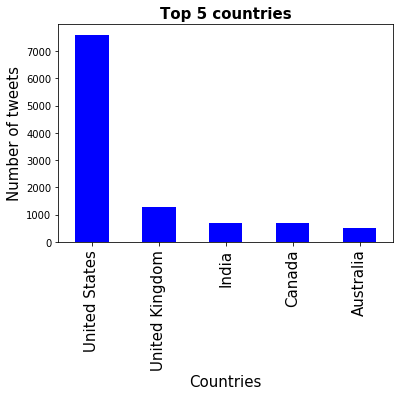

In [17]:
tweets_by_country = df_geo['place_country'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 countries', fontsize=15, fontweight='bold')
tweets_by_country[:5].plot(ax=ax, kind='bar', color='blue')

Country Analysis:


- On visualizing the total number of tweets with the country (of the user) it was determined that more 60% of the tweets came from United States followed by United Kingdom and India. Cryptocurrency was cointed in US and is mainly used as a source of transaction in the United States and European countries. In contrast crypo-currency is fairly a new term for many of the asian countries.

<b>4.1.2 Ploting the World Choropleth Map for the tweets with geo location to show the user distributions</b>

In [18]:
#ploting geo data on map
import plotly.plotly as py
import pandas as pd

df_geo_map = pd.read_msgpack('full_DataFrame/combined_data/tweets_with_geo_data.msg')
df_geo_map.head()


,id,created_at,geo,coordinates,place_country,place_name,place_full_name,place_place_type
48,9.635508e+17,Tue Feb 13 23:09:47 +0000 2018,None,None,The Netherlands,Amsterdam,"Amsterdam, The Netherlands",city
224,9.635509e+17,Tue Feb 13 23:10:12 +0000 2018,None,None,United States,Pennsylvania,"Pennsylvania, USA",admin
922,9.635514e+17,Tue Feb 13 23:12:07 +0000 2018,None,None,United Kingdom,Hatfield,"Hatfield, East",city
1370,9.635517e+17,Tue Feb 13 23:13:12 +0000 2018,None,None,United States,Georgia,"Georgia, USA",admin
1537,9.635518e+17,Tue Feb 13 23:13:39 +0000 2018,None,None,United Kingdom,Hereford,"Hereford, England",city


In [19]:
#counting number of tweets from individual country
group = df_geo_map[['place_country','id']].groupby(['place_country'], as_index=False).count()

* Tweets do not cointain the country code directly. It cointains the country name. Hence, we need to convert the names into Alpha-3 code which is readable by plotly. We fetched the wikipedia page for this purpose and converted the names.

In [20]:
#fetching country code from country name using wikipeida page
from bs4 import BeautifulSoup
import requests

url = "http://en.wikipedia.org/wiki/ISO_3166-1"
r = requests.get(url)
soup = BeautifulSoup(r.content, "lxml")

t = soup.findAll('table', {'class' : 'wikitable sortable'})[1]
L = []
cs = [th.findAll(text=True)[0] for th in t.findAll('th')]

for row in t.findAll("tr")[1:]:
    tds = row.findAll('td')
    raw_cols = [td.findAll(text=True) for td in tds]
    cols = []
    # country field contains differing numbers of elements, due to the flag -- 
    # only take the name
    cols.append(raw_cols[0][-1:][0])
    # for all other columns, use the first result text
    cols.extend([col[0] for col in raw_cols[1:]])
    L.append(cols)

df_wiki_country_name = pd.DataFrame(L, columns=cs)
df_wiki_country_name.head()

,English short name (upper/lower case),Alpha-2 code,Alpha-3 code,Numeric code,Link to,Independent
0,Afghanistan,AF,AFG,004,ISO 3166-2:AF,Yes
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,No
2,Albania,AL,ALB,008,ISO 3166-2:AL,Yes
3,Algeria,DZ,DZA,012,ISO 3166-2:DZ,Yes
4,American Samoa,AS,ASM,016,ISO 3166-2:AS,No


In [21]:
df_wiki_country_name = df_wiki_country_name[['English short name (upper/lower case)', 'Alpha-3 code']]

In [22]:
l = df_wiki_country_name['English short name (upper/lower case)'].tolist()
l2 = df_wiki_country_name['Alpha-3 code'].tolist()
d={l[i]:l2[i] for i,x in enumerate(l)}
#in wiki united states is named as United States of America. We need to add United States
d['United States'] = 'USA'

In [23]:
group['place_country_code'] = ''
for i in range(0,len(group)):
    try:
        group['place_country_code'][i] = d[group['place_country'][i]]
    except:
        group['place_country_code'][i] = None
group.head()

C:\Users\mkdv6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\mkdv6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,place_country,id,place_country_code
0,Albania,4,ALB
1,Algeria,1,DZA
2,Algérie,4,None
3,Allemagne,3,None
4,Angola,1,AGO


In [24]:
#droping the country names with non english words
group_lo = group.dropna(subset=['place_country_code'])
group_lo.head()

,place_country,id,place_country_code
0,Albania,4,ALB
1,Algeria,1,DZA
4,Angola,1,AGO
5,Antigua and Barbuda,1,ATG
6,Argentina,21,ARG


<b>Code snippet for ploting the World Choropleth Map using plotly</b>

In [25]:
#ploting the World Choropleth Map for the tweets with geo location
data = [ dict(
        type = 'choropleth',
        locations = group_lo['place_country_code'],
        z = group_lo['id'],
        text = group_lo['place_country'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'No. of Tweets'),
      ) ]

layout = dict(
    title = 'Global user distribution',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~mykttu/0 or inside your plot.ly account where it is named 'd3-world-map'


<b>If the map is not visible in the above cell please visit https://plot.ly/~mykttu/0/global-user-distribution/ to view the map</b>

* From the above map we can observe the user distribution over the world. We can see that USA out number all the other countries.
* However, this might not represnt the actual distribution as we have fewer geo tag and also in some countries twitter is banned. 

<h3>Analyzing the tweets with time</h3>

In [26]:
#reading tweets text file 
df_tweets = pd.read_msgpack('full_DataFrame/combined_data/texts_data/all_tweets.msg')
df_tweets.head()

,id,created_at,text,favorite_count,retweet_count
0,9.635508e+17,Tue Feb 13 23:09:37 +0000 2018,@cripto_miners Bitcoin Gold (BTG) is gaining p...,0.0,0.0
1,9.635508e+17,Tue Feb 13 23:09:38 +0000 2018,@Soc_Currency Successfully launch mainnet and ...,0.0,0.0
2,9.635508e+17,Tue Feb 13 23:09:38 +0000 2018,I don’t like #Ripple but I for sure am bullish...,0.0,0.0
3,9.635508e+17,Tue Feb 13 23:09:38 +0000 2018,RT @kucoincon_us: @kucoincom @covesting We're ...,0.0,0.0
4,9.635508e+17,Tue Feb 13 23:09:38 +0000 2018,New Airdrop https://t.co/CExaAFiCiN\n#Airdrop ...,0.0,0.0


In [27]:
len(df_tweets)

6406528

In [28]:
# converting to date to pd date time
df_tweets['created_at'] = pd.to_datetime(df_tweets['created_at'])

In [28]:
#kepping the bitcoin related tweets only
df_tweets = df_tweets[df_tweets['text'].str.contains("btc|bitcoin", na=False,case = False)]
df_tweets.head()

<b>Hourly tweets frequency over the periods of individual days</b>

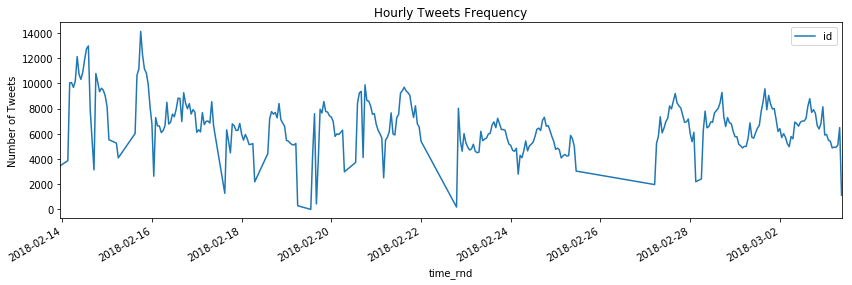

In [29]:
#adding new column into the dataframe to round the time in hours and count the tweets frequency
df_tweets['time_rnd'] = df_tweets['created_at'].dt.round('H')

#Ploting for hourly tweets frequency over the period
df_tweets[['time_rnd','id']].groupby(['time_rnd'], as_index=True).count().plot(figsize=(14,4))

# df_tweets[['time_rnd','id']].groupby(['time_rnd'], as_index=True).mean().plot()
plt.title('Hourly Tweets Frequency');
plt.ylabel('Number of Tweets');


Hourly Tweet Analysis:


- On plotting the tweet frequency with the time (in date) it was determined that the users were proactive to post about the 
bitcoin during the weekdays in comparison to the weekend days. As noticed from the graph above that number of tweets 
significantly dropped for the dates 02/16/18,02/23/18 and 03/02/18.

- In view of the above the fact can be concluded that the users were more proactive in nature (regarding cryptocurrency) during the weekdays than weekends. As a result lesser price fluctuations were also observed during weekends.

<b>Hourly tweets frequency over the periods</b>

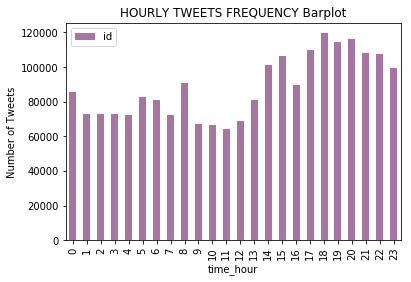

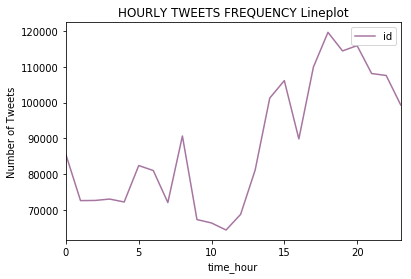

In [30]:
#extracting hour as a feature
df_tweets['time_hour']=df_tweets['created_at'].dt.hour

df_tweets[['time_hour','id']].groupby(['time_hour'], as_index=True).count().plot(kind='bar', color='#a675a1')
plt.title('HOURLY TWEETS FREQUENCY Barplot');
plt.ylabel('Number of Tweets');

df_tweets[['time_hour','id']].groupby(['time_hour'], as_index=True).count().plot(color='#a675a1')
plt.title('HOURLY TWEETS FREQUENCY Lineplot');
plt.ylabel('Number of Tweets');

# df_tweets[['time_hour','retweet_count']].groupby(['time_hour'], as_index=True).sum().plot(color='#a675a1')
# plt.title('HOURLY RE-TWEETS FREQUENCY Lineplot');
# plt.ylabel('Number of Re-Tweets');

Hourly Tweet Analysis:


- On plotting the tweet frequency with the time (in date) it was determined that most of the tweets were posted after the regular work hours (i.e. after 5pm). 
- The number of tweets increased significantly after 5pm till 8pm. 
- One probable reason for the same was that crypoto-currency is seen as an opportunity for people to invest their extra income in. Individuals prefer to carry out such activities after their work hours. 
- Therefore the number of tweets during the evening hours were found to be significantly higher than the day hours.

<h3>Tweet text analysis</h3>

<b>Defining definitions for processing the tweet text</b>

In [31]:
################################################	
# Stop word list
from nltk.corpus import stopwords
import string
from nltk.corpus import wordnet
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via','#']


################################################
# For creating a tokenize function for all tweet
import re
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
#     r'(?:@[\w_]+)', # @-mentions
#     r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    main_tokens = []
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
#         main_tokens = [token if len(token)>2 else none for token in tokens]
    for t in tokens:
        if(len(t)>3):
            main_tokens.append(t.lower())
    return main_tokens
 
tweet = 'RT @marcobonzanini: #just an example! :D http://example.com #NLP'
print(preprocess(tweet))
# ['RT', '@marcobonzanini', ':', 'just', 'an', 'example', '!', ':D', 'http://example.com', '#NLP']

['marcobonzanini', 'just', 'example', 'http://example.com']


The above code provides us the tokenize words removing the stopwrods and words less than 4 character. It also removes the special characters in the tweets. 

In [32]:
tweetList = df_tweets['text'].tolist()
len(tweetList)


6406528

<b>Most words and bigram words frequency barcharts</b>

In [33]:
import operator 
from collections import Counter
from nltk import bigrams

count_all = Counter()
count_bigram = Counter()
for line in tweetList:
#         tweet = json.loads(line)
#         keys = tweet.keys()
#         if 'text' in tweet:
    # Create a list with all the terms
    terms_all = [term for term in preprocess(line) if term not in stop]
    terms_bigram = bigrams(terms_all)
    # Update the counter
    count_all.update(terms_all)
    count_bigram.update(terms_bigram)
# Print the first 5 most frequent words
print(count_all.most_common(20))
print(count_bigram.most_common(20))

[('bitcoin', 1656528), ('crypto', 964932), ('blockchain', 867789), ('cryptocurrency', 861483), ('airdrop', 444503), ('join', 427746), ('ethereum', 338956), ('free', 336774), ('token', 275499), ('tokens', 263877), ('follow', 258369), ('price', 238771), ('2018', 219154), ('first', 213374), ('ripple', 200937), ('check', 193349), ('litecoin', 183290), ('like', 171239), ('giveaway', 170851), ('exchange', 165012)]
[(('bitcoin', 'ethereum'), 64954), (('blockchain', 'technology'), 55521), (('token', 'sale'), 51702), (('bitcoin', 'cash'), 51054), (('free', 'airdrop'), 50168), (('giving', 'away'), 47133), (('successfully', 'launch'), 46113), (('launch', 'mainnet'), 46049), (('mainnet', 'global'), 45751), (('global', 'exchanges'), 45599), (('exchanges', 'start'), 45454), (('cryptocurrency', 'blockchain'), 45435), (('start', 'trades'), 45057), (('bitcoin', 'gold'), 44496), (('blockchain', 'cryptocurrency'), 43499), (('join', 'telegram'), 43348), (('trades', 'balance'), 43141), (('gaining', 'popula

In [34]:
#extracting frequent word list for wordcloud
mf = list(count_all.most_common(2000))
mf_bigram = list(count_bigram.most_common(2000))
mf_word = []
mf_count = []
mf_bigram_word = []
mf_bigram_count = []

for i in range(0, len(mf)):
    mf_word.append(mf[i][0])
    mf_count.append(mf[i][1])
    
    l = list(mf_bigram[i][0])
    textT = l[0] + " " + l[1]
    mf_bigram_word.append(textT)
    mf_bigram_count.append(mf_bigram[i][1])
    

In [35]:
#storing the frequent words for wordcloud
fdf =  pd.DataFrame(
        {'words': mf_word,
         'count': mf_count
        })

fdf = fdf[['words', 'count']]
fdf.to_csv('full_DataFrame/combined_data/texts_data/freq_words.csv', index = False, encoding='utf-8')
fdf.head()

,words,count
0,bitcoin,1656528
1,crypto,243345
2,cryptocurrency,236360
3,blockchain,229424
4,ethereum,138010


In [36]:
#storing the frequent words bigrams for wordcloud
fdf =  pd.DataFrame(
        {'words': mf_bigram_word,
         'count': mf_bigram_count
        })

fdf = fdf[['words', 'count']]
fdf.to_csv('full_DataFrame/combined_data/texts_data/freq_words_bigram.csv', index = False, encoding='utf-8')
fdf.head()

,words,count
0,bitcoin ethereum,64954
1,bitcoin cash,51054
2,bitcoin gold,44496
3,gaining popularity,40792
4,popularity becoming,40563


In [37]:
#extracting frequent words for barcharts
mf = list(count_all.most_common(20))
mf_bigram = list(count_bigram.most_common(20))


mf_word = []
mf_count = []
mf_bigram_word = []
mf_bigram_count = []

for i in range(0, len(mf)):
    mf_word.append(mf[i][0])
    mf_count.append(mf[i][1])
    
    l = list(mf_bigram[i][0])
    textT = l[0] + " " + l[1]
    mf_bigram_word.append(textT)
    mf_bigram_count.append(mf_bigram[i][1])
    


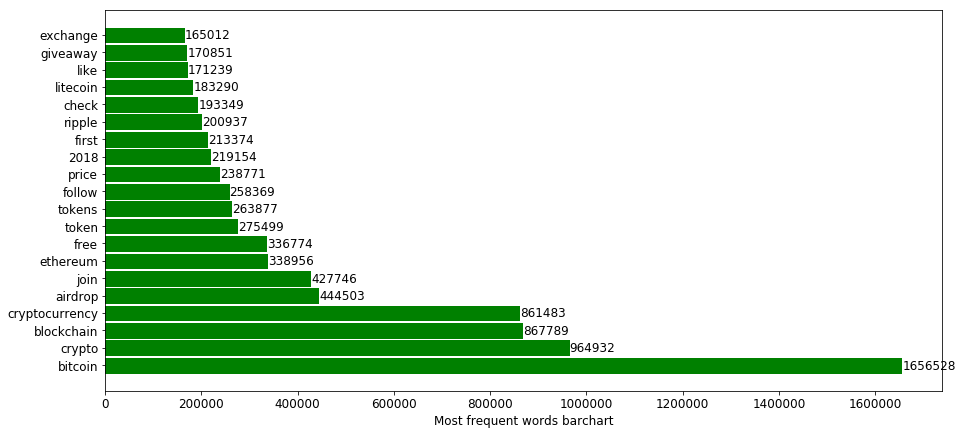

In [38]:
import mpld3, pandas as pd
mpld3.enable_notebook()
fdf =  pd.DataFrame(
        {'name': mf_word,
         'count': mf_count
        })
fdf.index = fdf['name'].tolist()
a = fdf['count']

x = list(a.index)
y = list(a)
plt.rc('font', size=12)  
fig, ax = plt.subplots(figsize=(15, 7))    

width = .90 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="green", align = "center")
for i, v in enumerate(y):
    ax.text(v + 3, i-.20, str(v), color='black', fontweight='normal')
ax.set_yticks(ind+width/30)
ax.set_yticklabels(x)
ax.set_xlabel("Most frequent words barchart")
#     plt.show()
# plt.savefig('data_analytics/images/' + 'frequent_words.png', dpi=100, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures
# plt.show()

<img src="https://mykabir.info/python_img/frequent_words.png">

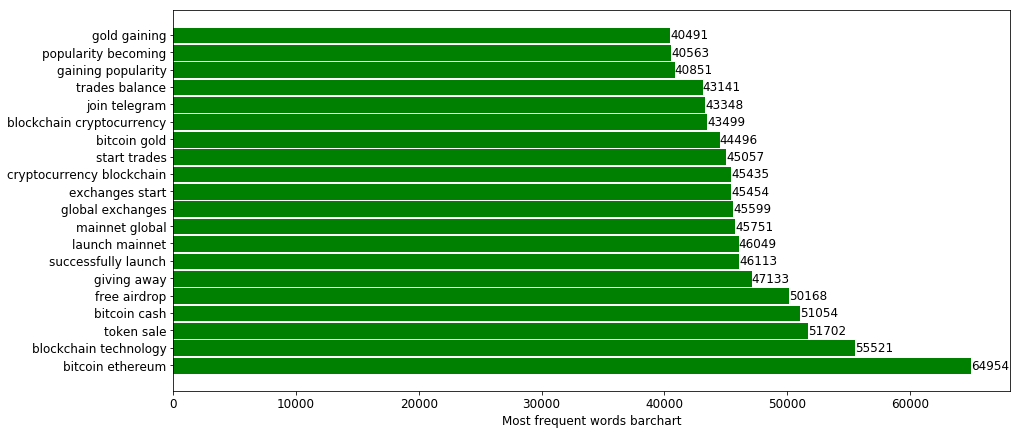

In [39]:
fdf =  pd.DataFrame(
        {'name': mf_bigram_word,
         'count': mf_bigram_count
        })
fdf.index = fdf['name'].tolist()
a = fdf['count']

x = list(a.index)
y = list(a)
plt.rc('font', size=12)  
fig, ax = plt.subplots(figsize=(15, 7))    

width = .90 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="green", align = "center")
for i, v in enumerate(y):
    ax.text(v + 3, i-.20, str(v), color='black', fontweight='normal')
ax.set_yticks(ind+width/30)
ax.set_yticklabels(x)
ax.set_xlabel("Most frequent words barchart")
#     plt.show()
# plt.savefig('data_analytics/images/' + 'frequent_words_bigram.png', dpi=100, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures
# plt.show()

<img src="https://mykabir.info/python_img/frequent_words_bigram.png">

<b>Wordcloud of most frequent words and frequent bigrams in the tweets</b>

In [40]:
# directory = join(parent_directory, 'frequent_words')
dir_map_frequent_words = glob.glob(join('', '*.csv'))
dir_map_frequent_words

['freq_words.csv', 'freq_words_bigram.csv']

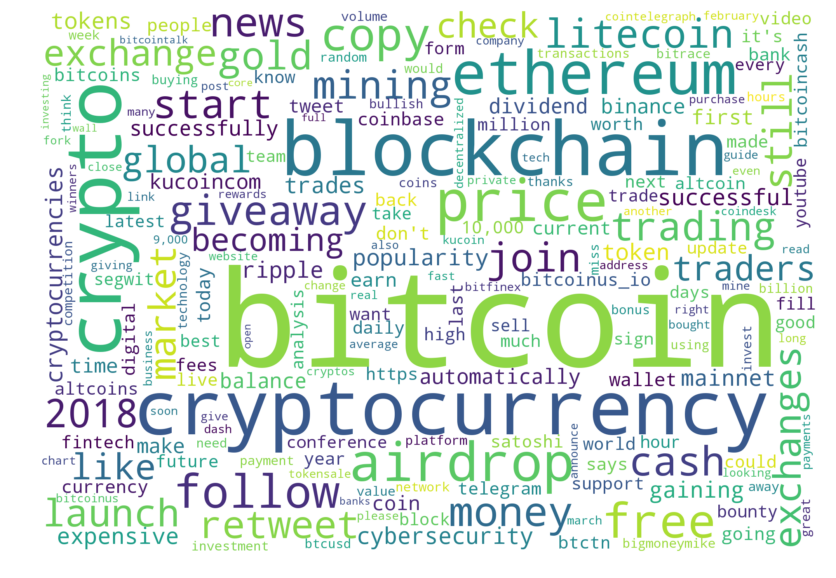

In [41]:
%matplotlib inline
#word_freq = {'kdshfsd':120, 'sdhfkjsd':100, 'hakjehr':200}
reader = csv.reader(open(dir_map_frequent_words[0], 'r',newline='\n'))
d = {}
for k,v in reader:
    val = int(v)
#     k = re.sub('[\W_]+', ' ', k, flags=re.UNICODE)
#     if k in d.keys():
#         d[k] = d[k]+val
#     else:
    d[k] = val

#word_freq = {'words':['absdf','ahsjdhfks', 'aksdfsdf','aksdfhkasdf'],'count':[123,50,20,100]}
#df_wc = pd.DataFrame(word_freq)
#wc = wordcloud.WordCloud(width=900,height=500, max_words=1628,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(d)
#wc = wordcloud.WordCloud(mode='RGB', background_color='white',max_font_size = 50).generate_from_frequencies(d)
#wc = wordcloud.WordCloud(width=3000,height=1200,relative_scaling=1, background_color='white',max_font_size = 50).generate_from_frequencies(d)
wc = wordcloud.WordCloud(width=2000,height=1400, background_color='white').generate_from_frequencies(d)
plt.figure( figsize=(15,10) )
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
#print(df_wc.iterrows)
#df_wc.iteritems

Top frequent words barcharts shows us only top 20 words. However, using wordcloud we can represent more words (2000) and observe whats going on. 

* From the above image we can observe some of the key words from the tweets which may have impact on the price. Words like [price, high, bullish, miss, buying, cybersecurity, fintech, investment, support, announce, gaining, bank, worth] etc. migh have impact on price.

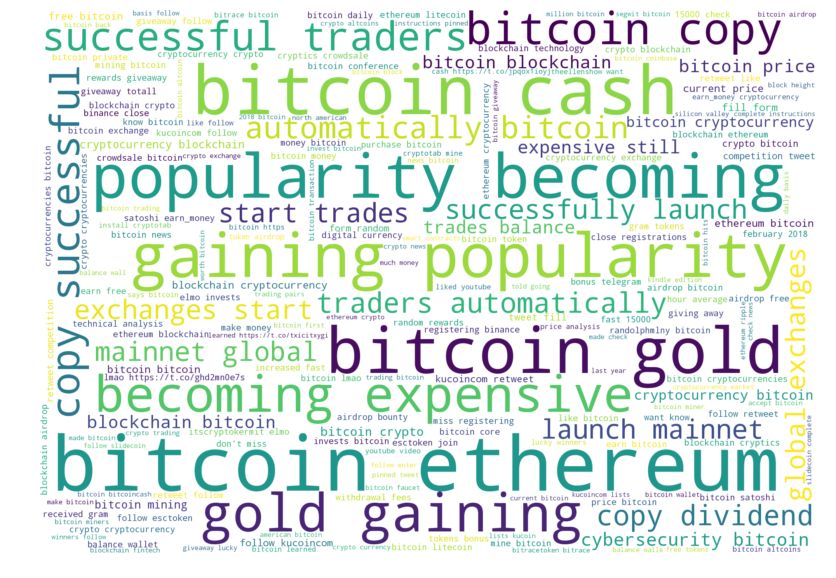

In [42]:
reader = csv.reader(open(dir_map_frequent_words[1], 'r',newline='\n'))
d = {}
for k,v in reader:
    val = int(v)
# #     k = re.sub('[\W_]+', ' ', k, flags=re.UNICODE)
#     if k in d.keys():
#         d[k] = d[k]+val
#     else:
    d[k] = val

#word_freq = {'words':['absdf','ahsjdhfks', 'aksdfsdf','aksdfhkasdf'],'count':[123,50,20,100]}
#df_wc = pd.DataFrame(word_freq)
#wc = wordcloud.WordCloud(width=900,height=500, max_words=1628,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(d)
#wc = wordcloud.WordCloud(mode='RGB', background_color='white',max_font_size = 50).generate_from_frequencies(d)
#wc = wordcloud.WordCloud(width=3000,height=1200,relative_scaling=1, background_color='white',max_font_size = 50).generate_from_frequencies(d)
wc = wordcloud.WordCloud(width=2000,height=1400, background_color='white').generate_from_frequencies(d)
plt.figure( figsize=(15,10) )
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
#print(df_wc.iterrows)
#df_wc.iteritems

Although, frequent words provide us some insight about whats going on in the tweets, but freqent bigram might give us more insight and meaning. The above wordcloud provides some more information comparing to first one. 

* Some bigrams (e.g. gaining populrity, mainnet global, launch mainnet, blockchain fintech, cybersecurity bitcoin, silicon valley, bitcoin airdrop, binance close, invest bitcoin, popularity becoming, bitcoin conference, might banned) can impact price.

<h3>Bitcoin price data analysis</h3>

In [43]:
#reding dta
price_data_hourly = pd.read_csv('full_DataFrame/combined_data/price/minute_data_till_05_Mar_2018_02_47_00.csv')

In [44]:
#converting time into pandas date time
price_data_hourly['time'] = pd.to_datetime(price_data_hourly['time'],unit='s')
price_data_hourly.head()

,Unnamed: 0,close,high,low,open,time,volumefrom,volumeto
0,1,11578.26,11596.28,11486.18,11538.28,2018-03-05 03:00:00,3664.68,42396705.80
1,2,11538.28,11538.69,11474.25,11480.68,2018-03-05 02:00:00,2774.88,31959684.94
2,3,11480.39,11484.15,11434.35,11480.71,2018-03-05 01:00:00,2135.86,24597762.27
3,4,11480.28,11519.34,11432.76,11503.94,2018-03-05 00:00:00,2808.32,32248067.11
4,5,11504.42,11539.79,11417.34,11417.53,2018-03-04 23:00:00,4044.50,46545746.62


In [45]:
#extracting hour as a feature
price_data_hourly['time_hour']=price_data_hourly['time'].dt.hour

In [46]:
price_data_hourly.head()

,Unnamed: 0,close,high,low,open,time,volumefrom,volumeto,time_hour
0,1,11578.26,11596.28,11486.18,11538.28,2018-03-05 03:00:00,3664.68,42396705.80,3
1,2,11538.28,11538.69,11474.25,11480.68,2018-03-05 02:00:00,2774.88,31959684.94,2
2,3,11480.39,11484.15,11434.35,11480.71,2018-03-05 01:00:00,2135.86,24597762.27,1
3,4,11480.28,11519.34,11432.76,11503.94,2018-03-05 00:00:00,2808.32,32248067.11,0
4,5,11504.42,11539.79,11417.34,11417.53,2018-03-04 23:00:00,4044.50,46545746.62,23


<b>Price vs Time Analysis (Average High and low price in hours)</b>

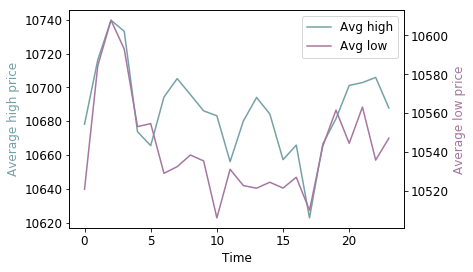

In [47]:
mpld3.disable_notebook()
group = price_data_hourly[['time_hour','high']].groupby(['time_hour'], as_index=False).mean()
x = group['time_hour']
tcount = group['high']
group = price_data_hourly[['time_hour','low']].groupby(['time_hour'], as_index=False).mean()
rcount = group['low']


fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Time")
host.set_ylabel("Average high price")
par1.set_ylabel("Average low price")


color1 = '#75a1a6'
color2 = '#a675a1'

p1, = host.plot(x, tcount, color=color1,label="Avg high")
p2, = par1.plot(x, rcount, color=color2, label="Avg low")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.savefig("pyplot_multiple_y-axis_price.png", bbox_inches='tight')

Price vs Time Analysis:

- On plotting the average high and low price of the bit coin during the different hours of the day it was observed that the prices remained steady during the early morning hours of the day. 

- However the prices start to change momentarily after 6am since a higher difference between the high and low value of the bitcoin is noticed for those hours.  As a result much higher number of variations were observed during the office hours (8am to 5pm). 

- As observed that even though the number of tweets posted about the bitcoin currency were higher after 5pm still the price variations in the bitcoin mainly occured during the office hours i.e. before 5pm. Therefore user activity related to bitcoin is mainly observed during the office hours however the social media activity of the same users on twitter was more prominient during the evening hours. 

<b>Price timechart with tooltips</b>

In [48]:
# #check for hourly patterns
# price_data_hourly['time','high'].plot()
# # df[['time_rnd','id']].groupby(['time_rnd'], as_index=True).mean().plot()
# plt.title('Hourly Tweets Frequency');
# plt.ylabel('Number of Tweets');
df_time_chart = price_data_hourly[['time', 'high', 'low']]
df_time_chart.head()

,time,high,low
0,2018-03-05 03:00:00,11596.28,11486.18
1,2018-03-05 02:00:00,11538.69,11474.25
2,2018-03-05 01:00:00,11484.15,11434.35
3,2018-03-05 00:00:00,11519.34,11432.76
4,2018-03-04 23:00:00,11539.79,11417.34


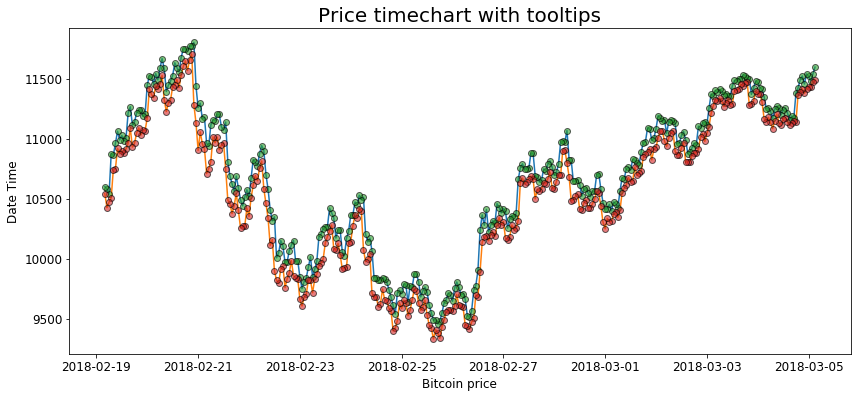

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mpld3
from mpld3 import plugins
mpld3.enable_notebook()
# Define some CSS to control our custom labels
css = """
table
{
  border-collapse: collapse;
}

th, td
{
  background-color: #cccccc;
}
table, th, td
{
  font-family:Arial, Helvetica, sans-serif;
  border: 1px solid black;
  text-align: right;
}
"""

fig, ax = plt.subplots(figsize=(14,6))
# labels = list(df_time_chart.columns.values)
ax.plot(df_time_chart.time, df_time_chart.high)
ax.plot(df_time_chart.time, df_time_chart.low)
labels = []
for i in range(len(df_time_chart)):
    label = df_time_chart.ix[[i], 1:3].T
    label.columns = ['{}'.format(df_time_chart['time'][i])]
    # .to_html() is unicode; so make leading 'u' go away with str()
    labels.append(str(label.to_html()))
    
points = ax.plot(df_time_chart.time, df_time_chart.high, 'o', mec='k', ms=6, mew=1, alpha=.6)

ax.set_xlabel('Bitcoin price')
ax.set_ylabel('Date Time')
ax.set_title('Price timechart with tooltips', size=20)

tooltip1 = plugins.PointHTMLTooltip(points[0], labels,
                                   voffset=10, hoffset=10, css=css)
labels2 = []
for i in range(len(df_time_chart)):
    label2 = df_time_chart.ix[[i], 1:3].T
    label2.columns = ['{}'.format(df_time_chart['time'][i])]
    # .to_html() is unicode; so make leading 'u' go away with str()
    labels2.append(str(label2.to_html()))

points2 = ax.plot(df_time_chart.time, df_time_chart.low, 'o', mec='k', ms=6, mew=1, alpha=.6)
tooltip2 = plugins.PointHTMLTooltip(points2[0], labels2,
                                   voffset=10, hoffset=10, css=css)

plugins.connect(fig, tooltip1, tooltip2)

The above time chart represents the bitcoin price over the time. Every single circle denotes the price in a specific hour. The chart also zoomable using the zoom icon which appears when we hover on the chart.

From the time chart we observe the following informations:

1. At the weekends and on the Monday price tends to go down.
2. Night time from 9pm to 12pm and at early morning price tends to move more comparing to other hours. 
3. The price went down mostly from February 23 to February 26.
4. We noticed from the hourly tweets frequency graph that, number of tweets significantly dropped for the dates 02/21/18, 02/23/18 and 03/02/18. In the above time chart we observe that the price also went down on those days.


<b>If the time chart is not visible in the above cell please visit https://mykabir.info/python_img/timechart.html to view the chart. Please check the 2nd figure on the webpage. Due to JS in appears twice, however the below one is fully functional.</b>

Below is a screenshot of the above time chart in for a quick reference. 

<img src="https://mykabir.info/python_img/price_timechart.png">